In [1]:
'''
CRISM cube visualization and analysis, created on 18/04/2023 by Beatrice Baschetti
last update: 2/08/23

With this code you can open CRISM MTRDR data cubes, visualize the data, produce RGB mineral maps (browse products),
extract spectra and perform spectral ratioing with 3 different methods (point, 5x5 ROI, polygon drawing).
'''

'\nCRISM cube visualization and analysis, created on 18/04/2023 by Beatrice Baschetti\nlast update: 2/08/23\n\nWith this code you can open CRISM MTRDR data cubes, visualize the data, produce RGB mineral maps (browse products),\nextract spectra and perform spectral ratioing with 3 different methods (point, 5x5 ROI, polygon drawing).\n'

# Import

In [3]:
#numpy
import numpy as np

#plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

#open envi image
from spectral import open_image

#image stretching
from skimage import exposure

#warnings
import warnings

# Open image

In [4]:
#opening I/F file
img = open_image('data/frt00009b5a_07_if165j_mtr3.hdr')
wavelength = np.array(img.metadata['wavelength']).astype(float)

#opening refined spectral parameter file
img_sr = open_image('data/frt00009b5a_07_sr165j_mtr3.hdr')
sr_names = img_sr.metadata['band names']

### Image copy 

In [5]:
#converting img to numpy array and putting no-values (65535.) to NaN (original data is kept in 'img' variable)
nan_img = np.copy(img[:,:,:])
nan_img[nan_img == 65535.]=np.nan

#converting img_sr to numpy array and putting no-values (65535.) to NaN (original data is kept in 'img_sr' variable)
nan_img_sr = np.copy(img_sr[:,:,:])
nan_img_sr[nan_img_sr == 65535.]=np.nan

# Cube visualization 

In [7]:
#compute the mean spectrum over the whole image + standard deviation

#mean
mean_spec = np.nanmean(nan_img.reshape(-1,nan_img.shape[-1]), axis = 0)
#std
mean_spec_std = np.nanstd(nan_img.reshape(-1,nan_img.shape[-1]), axis = 0)


#create enhanced RGB true color image (@visible wavelengths)

wav_channels = [26,15,1] #600nm,530nm,440nm
wav_channels_text = ','.join([f'{c}:{w:.0f}nm' for c,w in zip(['R','G','B'],wavelength[wav_channels])]) #channels text for plot
RGB = img[:,:,wav_channels]
#nan_RGB = np.where(RGB==65535., np.nan, RGB)


#histogram equalization----------#
#  1) masking no-data values for histogram equalization
#mask2D = (RGB[:,:,0] != 65535.).T


#  2) setting the correct stretch

#for ind, ch in enumerate(RGB.T):
    #RGB[:,:,ind] = exposure.equalize_hist(ch, mask = mask2D).T
#--------------------------------#

'''While histogram equalization has the advantage that it requires no parameters, 
it sometimes yields unnatural looking images. An alternative method is contrast stretching, 
where the image is rescaled to include all intensities that fall within the 2nd and 98th percentiles
'''

#contrast stretching: 
    
for ind, ch in enumerate (RGB.T):
    #masking no-data values
    ch_mask = ch != 65535. 
    #2nd and 98th percentile ignoring no-data values (if present)
    p2, p98 = np.nanpercentile(ch[ch_mask], (2, 98)) 
    RGB[:,:,ind] = exposure.rescale_intensity(ch, in_range=(p2, p98)).T
    

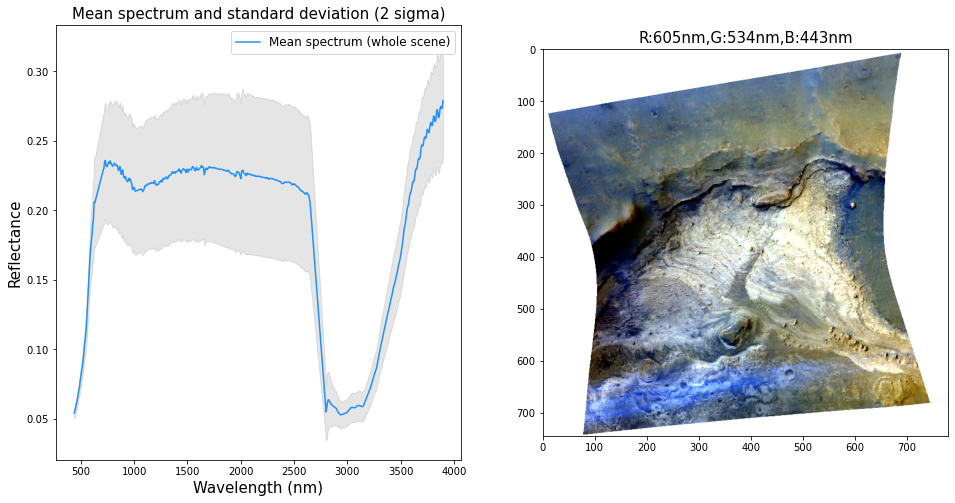

In [8]:
#plot
fig, axs = plt.subplots(ncols=2,figsize=[16,8])

#mean spectrum plot
axs[0].plot(wavelength, mean_spec, c='dodgerblue', label ='Mean spectrum (whole scene)')
axs[0].fill_between(wavelength, 
                    mean_spec-2*mean_spec_std, 
                    mean_spec+2*mean_spec_std, 
                    alpha=0.2, 
                    color='grey')
#title, labels, legend
axs[0].set_title('Mean spectrum and standard deviation (2 sigma)', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})

#img plot
axs[1].set_title(wav_channels_text, size = 15)
#making sure there is no data out of range (>1)
RGB = np.where(RGB>=1, 1, RGB)
axs[1].imshow(RGB)

### Save img

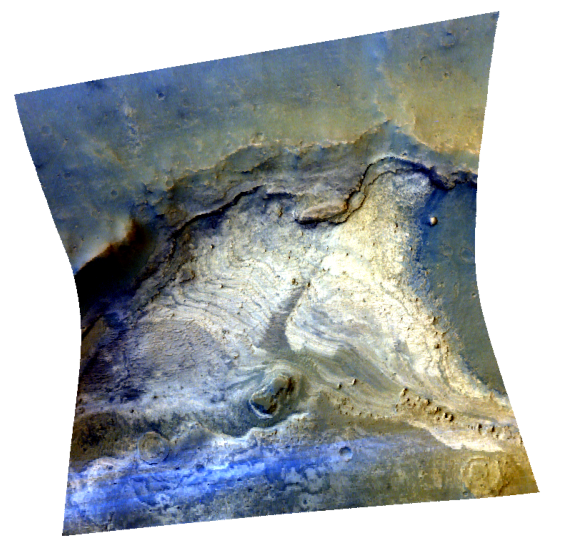

In [7]:
fig, axs = plt.subplots(figsize=(10,10))
im = axs.imshow(RGB)
plt.axis('off')
#save
plt.savefig('RGB.png', bbox_inches='tight', pad_inches=0, transparent = True)

# RGB browse products

choose the type of browse product you want by choosing three spectral parameters

standard browse products: 
1) MAF = (R: OLINDEX3, G:LCPINDEX2, B: HCPINDEX2); 
2) HYD = (R: SINDEX2, G:BD2100_2, B: BD1900_2);
3) PHY = (R: D2300, G:D2200, B:BD1900R2);
4) PFM = (R: BD2355, G:D2300, B:BD2290);
5) PAL = (R: BD2210_2, G:BD2190, B:BD2165);
6) HYS = (R:MIN2250, G:BD2250, B:BD1900R2);
7) ICE = (R: BD1900_2, G:BD1500_2, B:BD1435);
8) IC2 = (R:R3920, G:BD1500_2, B:BD1435);
9) CHL = (R:ISLOPE, G:BD3000, B:IRR2);
10) CAR = (R:D2300, G:BD2500H2, B:BD1900_2);
11) CR2 = (R:MIN2295_2480, G:MIN2345_2537, B:CINDEX2);

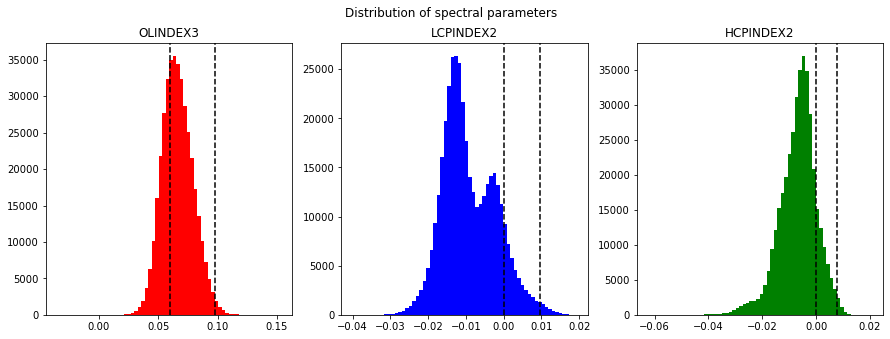

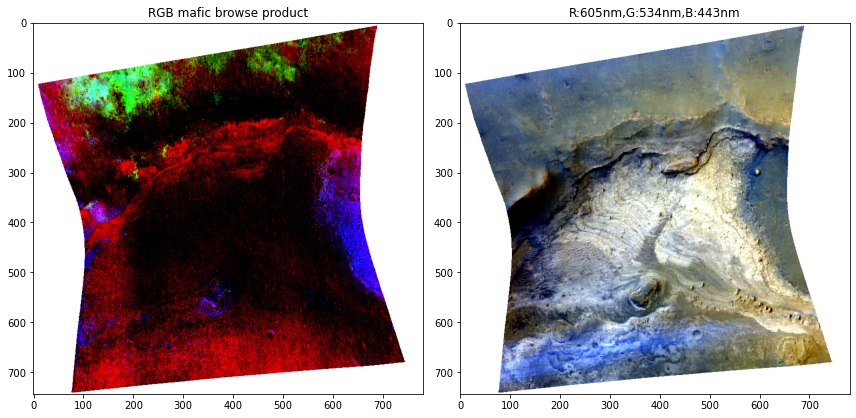

In [9]:
channels_names = ["OLINDEX3","LCPINDEX2","HCPINDEX2"] #-> put names of channels needed for the RGB here!
sr_channels_number = [sr_names.index(cn) for cn in channels_names] #retrieve channel index

#RGB array
RGB_browse = np.array(img_sr[:,:,sr_channels_number])
nan_RGB_browse = np.where(RGB_browse==65535., np.nan, RGB_browse) #same array but with nans instead of no-value data (65535.)



'''
#completely personalized: choose min & max values of RGB channels' histograms
#minimum and maximum stretch for the three channels, -> choose the best stretch with the aid of the histograms below
min_R = 0.06
max_R = 0.1
min_G = 0.0
max_G = 0.01
min_B = 0.0
max_B = 0.01

stretch = np.array([[min_R, max_R], 
                    [min_G, max_G], 
                    [min_B, max_B]])
'''

#semi-automatic: min value to be set manually, max value set automatically as 99th percentile of the histogram

#min values 
min_all = np.array([0.06, 0.0, 0.0]) #-> choose min values!
#max values (99th percentile)
max_all = np.nanpercentile(nan_img_sr[:, :, sr_channels_number], 99, axis=(0, 1))
#putting the two arrays (min_all, max_all) together
stretch = np.vstack((min_all, max_all)).T

#-----------histograms--------------
#plotting histogram to show distribution of the three selected spectral parameters
fig, axs = plt.subplots(ncols=3,figsize=[15,5])
fig.suptitle('Distribution of spectral parameters')

color = ['red', 'blue', 'green']
i = 0

for ax,ch in zip(axs,nan_RGB_browse.T):
    ax.hist(ch.flatten(), bins=64, color = color[i])
    ax.set_title(channels_names[i])
    ax.axvline(stretch[i,0], color='k', linestyle='--')
    ax.axvline(stretch[i,1], color='k', linestyle='--')
    i+=1
#-----------------------------------


#contrast stretching:    
for ind, ch in enumerate (RGB_browse.T):
    #masking no-data values
    ch_mask = ch != 65535. 
    #99th percentile ignoring no-data values
    p99 = np.nanpercentile(ch[ch_mask], 99) 
    RGB_browse[:,:,ind] = exposure.rescale_intensity(ch, in_range=(min_all[ind], p99)).T
    

'''
# another way to do the same kind of stretch below 
#(NB:for correct stretching RGB browse must not contain the no-data values):

# setting max and min values of RGB_browse to max and min stretch values
for ch,st in zip(nan_RGB_browse.T, stretch):
    st_min, st_max = st
    ch[ch > st_max] = st_max
    ch[ch < st_min] = st_min

#scaling values between 0 and 1
#Normalized data = ( data - min(data) )/( max(data) - min(data) )
nan_RGB_browse = (nan_RGB_browse-stretch[:,0])/(stretch[:,1]-stretch[:,0]) 
'''

#plot
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

#browse product plot
axs[0].set_title('RGB mafic browse product')
axs[0].imshow(RGB_browse)

#enhanced visible RGB image plot
axs[1].set_title(wav_channels_text)
axs[1].imshow(RGB)
plt.tight_layout()
#-----------------------------------

### save browse product

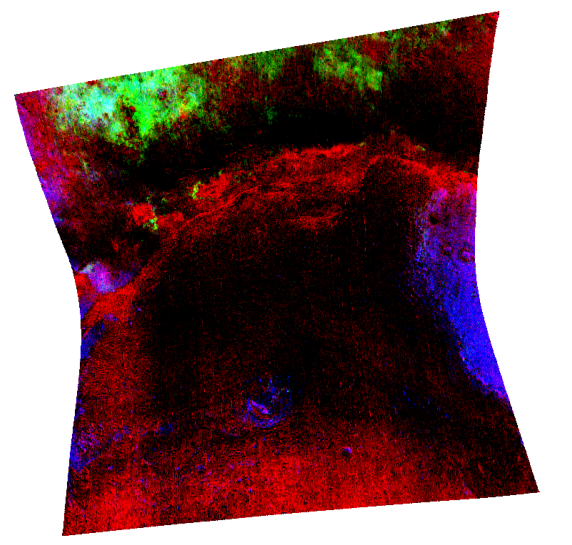

In [9]:
fig, axs = plt.subplots(figsize=(10,10))
im = axs.imshow(RGB_browse)
plt.axis('off')
#save
plt.savefig('RGB_browse.png', bbox_inches='tight', pad_inches=0, transparent = True)

# ROI selection with spectral ratioing
In this section it is possible to select a Numerator (target area) and Denominator (spectrally neutral area) ROI and extract a mean spectrum from both. Additionally, spectral ratio will be performed between the two ROIs (N/D) for spectral enhancement of N.
there are three possibilities: 
1) Point selection
2) 5x5 square selection
3) Polygon selection

NB:
To contrast residual column-dependent noise, the neutral area should be chosen on the same column of the target area. This reasoning is easy to apply in the sensor space CRISM images (like for example the TER products), but since the MTRDR dataset is map-projected, you need to take into account the hourglass shape of the image.  

In [10]:
#default matplotlib visualization is needed 
%matplotlib 

Using matplotlib backend: <object object at 0x7fbc825de320>


-> choose which RGB you want to visualize as a reference (you will have to select/draw your ROI using it as reference)
(default is the RGB_browse)

In [11]:
reference_RGB = RGB_browse #choose rgb

## Point selection


-> choose a target area (Numerator) by clicking on the image which appears after running the cell below.

In [23]:
#target area (numerator)
%matplotlib 
plt.imshow(reference_RGB)  
plt.title("Choose a target area")
#select pixel
coords_n = np.asarray(plt.ginput(timeout=-1, n=1, show_clicks = True)).astype(int).squeeze()
#print coordinates of selected pixel
print("coordinates of the secelted point -> X = {}; Y = {} ".format(coords_n[0], coords_n[1]))

Using matplotlib backend: MacOSX
coordinates of the secelted point -> X = 646; Y = 86 


-> choose a neutral area (Denominator) by clicking on the image which appears after running the cell below.

In [24]:
#neutral area (denominator)
plt.imshow(reference_RGB) 
plt.scatter(coords_n[0], coords_n[1], s=100, c='red', marker='+') #show the position of the target area as a reference to help choose the neutral area
plt.title("Choose a neutral area, target area is shown in red")
#select pixel
coords_d = np.asarray(plt.ginput(timeout=-1, n=1, show_clicks = True)).astype(int).squeeze()
#print coordinates of selected pixel
print("coordinates of the secelted point -> X = {}; Y = {} ".format(coords_d[0], coords_d[1]))

coordinates of the secelted point -> X = 137; Y = 678 


In [28]:
#plots----------------------------------------

fig, axs = plt.subplots(ncols = 2, figsize=[12,8])
#coordinates
x_n, y_n = int(coords_n[0]), int(coords_n[1])
x_d, y_d = int(coords_d[0]), int(coords_d[1])

#plot 1 (target and neutral spectra)

'''
careful! nan_img.shape = (744, 781, 489) 
 
lines   = 744 (y dimension with matplotlib)
samples = 781 (x dimension with matplotlib)
bands   = 489 (wavelengths)

so y goes first than x when extracting the specra from nan_img
'''

axs[0].plot(wavelength, nan_img[y_n, x_n, :], label='target spectrum', color='red')
axs[0].plot(wavelength, nan_img[y_d, x_d, :], label='neutral spectrum', color='grey')
#title, labels, legend
axs[0].set_title('Single pixel spectra', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})
axs[0].set_xlim(400, 2700)

#plot 2 (image)
axs[1].set_title('target ROI position: X = {}; Y = {}\nneutral ROI position: X = {}; Y = {} '.format(x_n, y_n, x_d, y_d), size = 20)
axs[1].imshow(reference_RGB)
plt.scatter(x_n, y_n, s=100, c='red', marker='+')
plt.scatter(x_d, y_d, s=100, c='grey', marker='+')

plt.tight_layout()

In [27]:
nan_img.shape

(744, 781, 489)

In [15]:
#plots----------------------------------------

#ratioed spectrum plot
fig, axs = plt.subplots(ncols = 2, figsize=[12,8])
#plot 1 (spectrum)
axs[0].plot(wavelength, nan_img[y_n, x_n, :], label='target spectrum', color='red')
axs[0].plot(wavelength, nan_img[y_d, x_d, :], label='neutral spectrum', color='grey')
#title, labels, legend
axs[0].set_title('Single pixel spectra', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})
axs[0].set_xlim(400, 2700)

#plot 2
axs[1].plot(wavelength, nan_img[y_n, x_n, :]/nan_img[y_d, x_d, :], label ='ratioed spectrum', color='red')
#title, labels, legend
axs[1].set_title('Ratioed spectrum', size=15)
axs[1].set_xlabel('Wavelength (nm)', size=15)
axs[1].set_ylabel('Relative reflectance', size=15)
axs[1].legend(prop={'size': 12})
axs[1].set_xlim(400, 2700)

(400.0, 2700.0)

In [20]:
#save spectrum to txt
header = "Single pixel spectrum data.\nTarget spectrum coord: X={}, Y={}; Neutral spectrum coord: X={}, Y={}\n".format(x_n,y_n,x_d,y_d)+"wavelength, target spectrum, neutral spectrum, ratioed spectrum (target/neutral)" 
np.savetxt("point_spectrum.txt", 
           np.c_[wavelength, nan_img[y_n, x_n, :], nan_img[y_d, x_d, :],nan_img[y_n, x_n, :]/nan_img[y_d, x_d, :]], 
           header = header)

## 5x5 square selection

-> choose a target area by clicking on the image which appears after running the cell below. 
The coordinates selected will be used as the centre of 5x5 the box

In [21]:
#target area
%matplotlib 
plt.imshow(reference_RGB)
#select ROI (box)
coords_n = np.asarray(plt.ginput(timeout=-1, n=1, show_clicks = True)).astype(int).squeeze() # Select the pixels with the cursor
#print central coordinates of ROI (box)
print("coordinates of the centre of the box -> X = {}; Y = {} ".format(coords_n[0], coords_n[1]))

Using matplotlib backend: MacOSX
coordinates of the centre of the box -> X = 549; Y = 495 


-> choose a neutral area by clicking on the image which appears after running the cell below. 
The coordinates selected will be used as the centre of 5x5 the box

In [22]:
#neutral area
plt.imshow(reference_RGB)

#show the position of the target area as a reference to help choose the neutral area
plt.gca().add_patch(Rectangle((coords_n[0]-2.5,coords_n[1]-2.5),5,5,
                    edgecolor='none',
                    facecolor='red',
                    lw=4))

plt.title("Choose a neutral area, center of target area is shown in red")
#select ROI (box)
coords_d = np.asarray(plt.ginput(timeout=-1, n=1, show_clicks = True)).astype(int).squeeze() # Select the pixels with the cursor
#print central coordinates of ROI (box)
print("coordinates of the centre of the box -> X = {}; Y = {} ".format(coords_d[0], coords_d[1]))

coordinates of the centre of the box -> X = 446; Y = 495 


In [115]:
x_n, y_n = int(coords_n[0]), int(coords_n[1]) #coordinates of the centre of the box (target)
x_d, y_d = int(coords_d[0]), int(coords_d[1]) #coordinates of the centre of the box (neutral spectrum)
n = 2 #n*2+1 = length of the sides of the box, selected pixel is at the centre of the box

#building mask to extract the spectra within the ROI

'''
careful! nan_img.shape = (744, 781, 489) 
 
lines   = 744 (y dimension with matplotlib)
samples = 781 (x dimension with matplotlib)
bands   = 489 (wavelengths)

so y goes first than x when extracting the specra from nan_img
'''

#target
mask_n = np.full(nan_img[:,:,0].shape, False) 
mask_n[y_n-n:y_n+n+1, x_n-n:x_n+n+1] = True  #y->data cube rows ; x->data cube columns 

#neutral
mask_d = np.full(nan_img[:,:,0].shape, False) #y->data cube rows ; x->data cube columns 
mask_d[y_d-n:y_d+n+1, x_d-n:x_d+n+1] = True 

#apply mask 
ROI_spectra_n = nan_img[mask_n==True,:] #selected spectra
ROI_spectra_d = nan_img[mask_d==True,:] #selected spectra
#print('Shape of array with selected spectra\ntarget:{}\nneutral{}'.format(ROI_spectra_n.shape, ROI_spectra_d.shape))

#computing mean and standard deviation of spectra ignoring some warnings
#nominator
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    print(f'Computing the mean of {np.count_nonzero(np.nansum(ROI_spectra_n, axis = 1))} spectra (target)...')
    ROI_spectra_mean_n = np.nanmean(ROI_spectra_n, axis = 0) #computing mean ignoring NaNs
    ROI_stdev_n = np.nanstd(ROI_spectra_n, axis = 0) #computing stdev ignoring NaNs
    
    print(f'Computing the mean of {np.count_nonzero(np.nansum(ROI_spectra_d, axis = 1))} spectra (neutral)...')
    ROI_spectra_mean_d = np.nanmean(ROI_spectra_d, axis = 0) #computing mean ignoring NaNs
    ROI_stdev_d = np.nanstd(ROI_spectra_d, axis = 0) #computing stdev ignoring NaNs
    
print("done!")

Computing the mean of 25 spectra (target)...
Computing the mean of 25 spectra (neutral)...
done!


In [116]:
#plots----------------------------------------

fig, axs = plt.subplots(ncols = 2, figsize=[12,8])

#plot 1 (target and neutral spectrum)

#target
axs[0].plot(wavelength, ROI_spectra_mean_n, label='target mean spectrum', c='red')
axs[0].fill_between(wavelength, ROI_spectra_mean_n+2*ROI_stdev_n, ROI_spectra_mean_n-2*ROI_stdev_n, alpha=0.3, color = 'lightcoral')
#neutral
axs[0].plot(wavelength, ROI_spectra_mean_d, label='neutral mean spectrum', c='grey')
axs[0].fill_between(wavelength, ROI_spectra_mean_d+2*ROI_stdev_d, ROI_spectra_mean_d-2*ROI_stdev_d, alpha=0.3, color = 'lightgrey')
#title, labels, legend
axs[0].set_title('Square ROI mean spectra with standard dev. (2 sigma)', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})
axs[0].set_xlim(400, 2700)

#plot 2 (image)
axs[1].set_title('ROI', size = 20)
axs[1].imshow(reference_RGB)
#target
cmap = colors.ListedColormap(['none', 'red']) #plot colors
axs[1].imshow(mask_n, interpolation='None', cmap = cmap)
#neutral
cmap = colors.ListedColormap(['none', 'grey']) #plot colors
axs[1].imshow(mask_d, interpolation='None', cmap = cmap)

plt.tight_layout()

In [117]:
#plots----------------------------------------

#ratioed spectrum plot
fig, axs = plt.subplots(ncols = 2, figsize=[12,8])

#plot 1 (target and neutral spectra)
#target
axs[0].plot(wavelength, ROI_spectra_mean_n, label='target mean spectrum', c='red')
axs[0].fill_between(wavelength, 
                    ROI_spectra_mean_n+2*ROI_stdev_n, 
                    ROI_spectra_mean_n-2*ROI_stdev_n, 
                    alpha=0.3, 
                    color = 'lightcoral')
#neutral
axs[0].plot(wavelength, ROI_spectra_mean_d, label='neutral mean spectrum', c='grey')
axs[0].fill_between(wavelength, 
                    ROI_spectra_mean_d+2*ROI_stdev_d, 
                    ROI_spectra_mean_d-2*ROI_stdev_d, 
                    alpha=0.3, 
                    color = 'lightgrey')
#title, labels, legend
axs[0].set_title('Square ROI mean spectra with standard dev. (2 sigma)', size=15)
axs[0].set_xlabel('Wavelength (nm)', size=15)
axs[0].set_ylabel('Reflectance', size=15)
axs[0].legend(prop={'size': 12})
axs[0].set_xlim(400, 2700)

#plot 2 (ratioed spectrum)
axs[1].plot(wavelength, ROI_spectra_mean_n/ROI_spectra_mean_d, label='ratioed spectrum', c='red')

#title, labels, legend
axs[1].set_title('Ratioed spectrum', size=15)
axs[1].set_xlabel('Wavelength (nm)', size=15)
axs[1].set_ylabel('Relative reflectance', size=15)
axs[1].legend(prop={'size': 12})
axs[1].set_xlim(400, 2700)

(400.0, 2700.0)

In [45]:
#save mean spectrum to txt
header = "5x5 ROI spectra\ntarget spectrum coord: X={}, Y={}, neutral spectrum coord: X={}, Y={}".format(x_n,y_n,x_d,y_d) + "\nWavelength, target spectrum, neutral spectrum, ratioed spectrum"
np.savetxt("box_spectrum.txt", 
           np.c_[wavelength, ROI_spectra_mean_n, ROI_spectra_mean_d, ROI_spectra_mean_n/ROI_spectra_mean_d], 
           header = header)


## Polygon selection
(Draw a polygon around the ROI)

In [118]:
import poly_selection

-> draw the target polygon and visualize the selected area by running the two cells below

In [79]:
#numerator polygon
%matplotlib 
polygon_n = poly_selection.PolygonSelect(reference_RGB) #polygon contains the vertexes of the drawn polygon

Click on the figure to create a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.


In [80]:
#creating a mask to visualize the polygonal selection
mask_n = poly_selection.CreateMask(polygon_n, reference_RGB) 

-> draw the neutral polygon and visualize the selected area by running the two cells below

In [81]:
#denominator polygon
polygon_d = poly_selection.PolygonSelect(reference_RGB) #polygon contains the vertexes of the drawn polygon

Click on the figure to create a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.


In [82]:
#creating a mask to visualize the polygonal selection
mask_d = poly_selection.CreateMask(polygon_d, reference_RGB) 

In [83]:
# Extract the points of the RGB image that are inside the polygons and get mean spectrua and std dev

print('Number of points inside the drawn polygons:\ntarget:{}\nneutral:{}'.format(len(reference_RGB[mask_n]), len(reference_RGB[mask_d])))

#--------target (numerator)--------
#masking
img_masked = nan_img[mask_n == True,:]
print(f'{img_masked.shape=}')
#mean
mean_poly_spec_n = np.mean(img_masked, axis = 0)
#std
stdev_poly_spec_n = np.std(img_masked, axis = 0)
      
#--------neutral (denominator)--------
#masking
img_masked = nan_img[mask_d == True,:]
print(f'{img_masked.shape=}')
#mean
mean_poly_spec_d = np.mean(img_masked, axis = 0)
#std
stdev_poly_spec_d = np.std(img_masked, axis = 0)

Number of points inside the drawn polygons:
target:4939
neutral:6583
img_masked.shape=(4939, 489)
img_masked.shape=(6583, 489)


In [120]:
#plots----------------------------------------
fig, axs = plt.subplots(ncols = 2, figsize=[15,8])

#plot 1 (target and neutral spectra)

#target
axs[0].plot(wavelength, mean_poly_spec_n, c='red', label = 'target mean spectrum')
axs[0].fill_between(
    wavelength, 
    mean_poly_spec_n+2*stdev_poly_spec_n, 
    mean_poly_spec_n-2*stdev_poly_spec_n, 
    color='lightcoral',
    alpha=0.3)
#neutral
axs[0].plot(wavelength, mean_poly_spec_d, c='grey', label = 'neutral mean spectrum')
axs[0].fill_between(
    wavelength, 
    mean_poly_spec_d+2*stdev_poly_spec_d, 
    mean_poly_spec_d-2*stdev_poly_spec_d, 
    color='lightgrey',
    alpha=0.3)
#title, labels, legend
axs[0].set_title("Polygonal ROI selection, spectra with standard deviation (2 sigma)", size=16)
axs[0].set_ylabel('Reflectance', size = 15)
axs[0].set_xlabel('Wavelength (nm)', size = 15)
axs[0].legend(prop={'size': 12}, loc='lower left')

#plot 2 (image)

axs[1].imshow(reference_RGB)
cmap = colors.ListedColormap(['none', 'red']) #plot colors
axs[1].imshow(mask_n, alpha = 0.5, cmap=cmap)
cmap = colors.ListedColormap(['none', 'grey']) #plot colors
axs[1].imshow(mask_d, alpha = 0.5, cmap=cmap)
axs[1].set_title("Polygonal ROI, selected area", size=16)


Text(0.5, 1.0, 'Polygonal ROI, selected area')

In [85]:
#plots----------------------------------------
#ratioed spectrum plot

fig, axs = plt.subplots(ncols = 2, figsize=[15,8])

#plot 1 (target and neutral spectra)

#target
axs[0].plot(wavelength, mean_poly_spec_n, c='red', label = 'target mean spectrum')
axs[0].fill_between(
    wavelength, 
    mean_poly_spec_n+2*stdev_poly_spec_n, 
    mean_poly_spec_n-2*stdev_poly_spec_n, 
    color='lightcoral',
    alpha=0.3)
#neutral
axs[0].plot(wavelength, mean_poly_spec_d, c='grey', label = 'neutral mean spectrum')
axs[0].fill_between(
    wavelength, 
    mean_poly_spec_d+2*stdev_poly_spec_d, 
    mean_poly_spec_d-2*stdev_poly_spec_d, 
    color='lightgrey',
    alpha=0.3)
#title, labels, legend
axs[0].set_title("Polygonal ROI selection, spectra with standard deviation (2 sigma)", size=16)
axs[0].set_ylabel('Reflectance', size = 15)
axs[0].set_xlabel('Wavelength (nm)', size = 15)
axs[0].legend(prop={'size': 12}, loc='lower left')

#plot 2 (ratio)
#target
axs[1].plot(wavelength, mean_poly_spec_n/mean_poly_spec_d, c='red', label = 'ratioed spectrum')
#title, labels, legend
axs[1].set_title("Polygonal ROI selection, ratioed spectrum", size=16)
axs[1].set_ylabel('Relative reflectance', size = 15)
axs[1].set_xlabel('Wavelength (nm)', size = 15)
axs[1].legend(prop={'size': 12}, loc='lower left')


In [77]:
#save mean spectrum to txt
header = "polygonal ROI spectra\ntarget spectrum: mean over {} spectra\nneutral spectrum: mean over {} spectra".format(len(reference_RGB[mask_n]), len(reference_RGB[mask_d]))+ "\nWavelength, target spectrum, neutral spectrum, ratioed spectrum"
np.savetxt("poly_spectrum.txt", 
           np.c_[wavelength, mean_poly_spec_n, mean_poly_spec_d, mean_poly_spec_n/mean_poly_spec_d], 
           header = header)